In [2]:
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec
from scipy.integrate import odeint

# %pip install gekko
from gekko import GEKKO
m = GEKKO()

## Exercice 1 - Préliminaires

Résolution numérique du problème
\begin{align*}
\inf_{K} J \\
\text{avec} \quad J: &\mathbb{R}\times\mathbb{R} \to \mathbb{R} \\
& (x_1, x_2) \mapsto x_1^2 + x_2^2 - 14x_1 - 6x_2 - 7 \\ 
\end{align*}
et
\begin{align*}
K=\{(x_1, x_2) \in \mathbb{R}^2 \, | \, g_1(x_1,x_2) \leq 0 \, \text{  et  } g_2(x_1,x_2) \leq 0 \} \\
\text{où  } \, g_1(x_1,x_2) = x_1 + x_2 -2 \text{  et  } g_2(x_1,x_2) = x_1 + 2x_2 -3
\end{align*}

In [7]:
# Initialize Model
m = GEKKO(remote=True)

#define parameter
eq = m.Param(value=40)

#initialize variables
x1,x2 = [m.Var() for i in range(2)]

#initial values
x1.value = 5
x2.value = -1

#Equations
m.Equation(x1+x2<=2)
m.Equation(x1+2*x2<=3)

#Objective
m.Obj(x1**2+x2**2-14*x1-6*x2-7)

#Set global options
m.options.IMODE = 3 #steady state optimization

#Solve simulation
m.solve() # solve on public server

#Results
print('')
print('Results')
print('x1: ' + str(x1.value))
print('x2: ' + str(x2.value))

apm 46.193.68.184_gk_model6 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            3
   Residuals    :            3
 
 Number of state variables:              4
 Number of total equations: -            2
 Number of slack variables: -            2
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program con

## Exercice 2 - Controle d'un tram

### 1ere version

Final Time: 2.3979143983


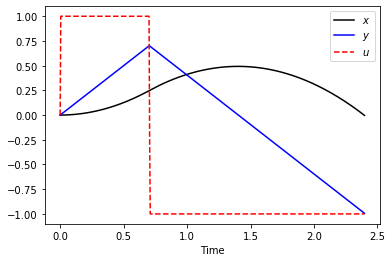

In [8]:
m = GEKKO() # initialize GEKKO
nt = 501
m.time = np.linspace(0,1,nt)      ## Time discretisation != time optimisation

# Variables
x = m.Var(value=0)
y = m.Var(value=0)
p = np.zeros(nt) # final time = 1
p[-1] = 1
final = m.Param(value=p)
# print(help(final))

# optimize final time
tf = m.FV(value=2.0,lb=0.00001,ub=20.0)
tf.STATUS = 1

# control changes every time period
u = m.MV(value=0,lb=-1,ub=1)
u.STATUS = 1
m.Equation(x.dt()==y*tf)
m.Equation(y.dt()==u*tf)
# m.Equation(x*final==0)         ## Fixons x et y au temps final
# m.Equation(y*final==-1)
# m.Obj(tf)
m.Obj(tf+1e5*(x*final)**2+1e5*(y*final+1)**2)       ## Penalisation

m.options.IMODE = 6
m.solve(disp=False)
print('Final Time: ' + str(tf.value[0]))

tm = np.linspace(0,tf.value[0],nt)
plt.figure(1)
plt.plot(tm,x.value,'k-',label=r'$x$')
plt.plot(tm,y.value,'b-',label=r'$y$')
plt.plot(tm,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
# plt.savefig("Tex/img/Exo2Ver1.png")
plt.show();

### 2ème version


On pose $z(t)= \frac{1}{2} ( x^\prime(t)^2 + x(t)^2) $, le probleme revient à résoudre $\inf_{u\in \cal U} (\xi T + (1-\xi)z(T))$ ou $\xi \in [0,1]$ et les contraintes
\begin{align*}
x^\prime (t)&=y(t) \\
y^\prime (t)&=u(t) \\
z^\prime (t)&= \frac{1}{2} (x^{\prime}(t)^2 + x(t)) \\
(x(0),y(0),z(0)) &= (0,0,0) \\
x(T)&=0 \\
y(T) &\in [-1-\epsilon,-1+\epsilon]
\end{align*}

Final Time: 2.324238823
Final Cost: 0.6669185362669


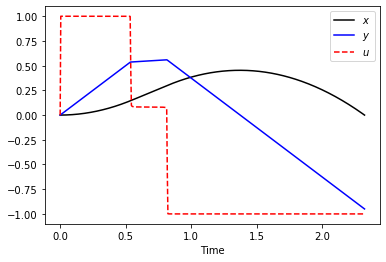

In [9]:
m = GEKKO() # initialize GEKKO
nt = 501
m.time = np.linspace(0,1,nt)      ## Time discretisation != time optimisation

# Variables
x = m.Var(value=0)
y = m.Var(value=0)
z = m.Var(value=0)
p = np.zeros(nt)
p[-1] = 1  # final time = 1
final = m.Param(value=p)
# print(help(final))

# optimize final time
tf = m.FV(value=2.0,lb=0.1,ub=20.0) 
tf.STATUS = 1

# control changes every time period
u = m.MV(value=0,lb=-1,ub=1)
u.STATUS = 1
m.Equation(x.dt()==y*tf)
m.Equation(y.dt()==u*tf)
m.Equation(z.dt()==0.5*(x.dt())**2+(x)**2)

## Pour la normalisation
tNorm = 2.3226859293        ## 0.71443780911
zNorm = 0.05670920959       ## 0.5197022761
# penNorm = 31943049.0632569

eps = 0.05
xi = m.MV(value=0.01,lb=0.000,ub=1.000)

m.Obj(xi*tf/tNorm + (1-xi)*z*final/zNorm + (1e5*(x*final)**2 + 1e5*m.max2(-1-eps-y*final,0)**2+1e5*m.max2(y*final+1-eps,0)**2))

m.options.IMODE = 6
m.solve(disp=False)
print('Final Time: ' + str(tf.value[0]))
print('Final Cost: ' + str(xi.value[0]*tf.value[0]+(1-xi.value[0])*z.VALUE[-1]))
# print(xi.value[0])

tm = np.linspace(0,tf.value[0],nt)
plt.figure(1)
plt.plot(tm,x.value,'k-',label=r'$x$')
plt.plot(tm,y.value,'b-',label=r'$y$')
plt.plot(tm,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
# plt.savefig("Tex/img/Exo2Verif.png")
plt.show()

## Exercice 3 - Controle d'insectes

### Points d'équilibre

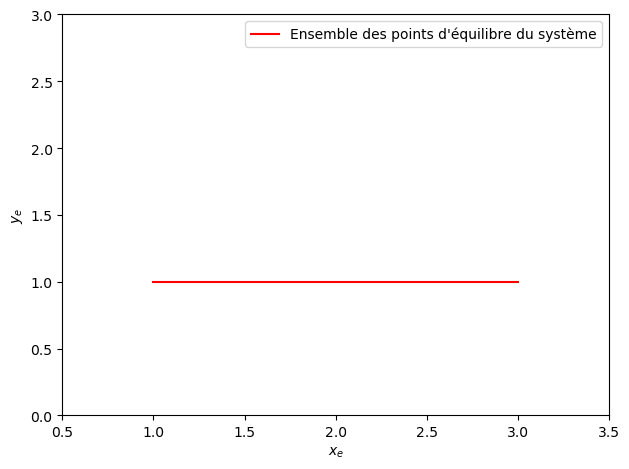

In [20]:
x = [1, 3]
y = [1, 1]

plt.xlim([0.5, 3.5])
plt.ylim([0, 3])
plt.xlabel(r'$x_e$')
plt.ylabel(r'$y_e$')
plt.plot(x,y, "r", label="Ensemble des points d'équilibre du système")
plt.legend()
plt.tight_layout()
plt.savefig("Tex/img/NewEq.png")

### Portrait de phase

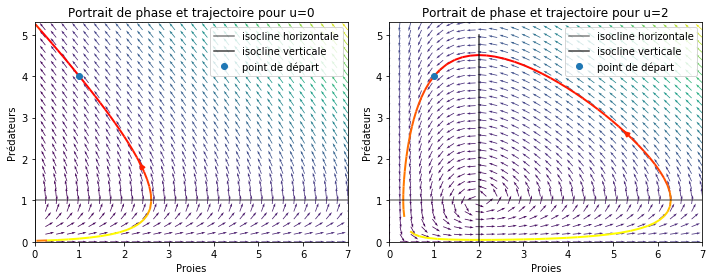

In [34]:
## ectors direction

def plotCase(u, ax):
    Y, X = np.mgrid[-0:5.3:30j, -0:7:30j]
    U = X*(1 - Y)
    V = -Y*(u-X)

    M = (np.hypot(U, V))
    # This is to avoid any divisions when normalizing
    M[ M == 0] = 1.
    # Normalize the length of each arrow (optional)
    U /= M
    V /= M
    widths = np.linspace(0, 2, X.size)
    Q = ax.quiver(X, Y, U, V, M, linewidths=widths, scale=8, scale_units='inches')

    # My starting points 
    seed_points = np.array([[1], [4]])

    strm = ax.streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn',start_points=seed_points.T)
    # fig.colorbar(strm.lines)
    ax.set_title('Portrait de phase et trajectoire pour u={}'.format(u))
    x, y = [0, 7], [1, 1]
    # ax.plot(x,y, 'k-', alpha=0.5, label='isocline horizontale')
    x, y = [u, u], [0, 5]
    # ax.plot(x,y, 'k-', alpha=0.75 , label='isocline verticale')
    ax.set_xlabel("Proies")
    ax.set_ylabel("Prédateurs")
    ## 2nd approach
    # def ode(X, t=0):
    #     dx = X[0]*(1 - X[1])
    #     dy = -X[1]*(2-X[0])
    #     return [dx, dy]

    # X0 = [1,4]
    # t = np.linspace(0,10, 1000)
    # sol = odeint(ode, X0, t)
    # # print(sol)
    # ax0.plot(sol[:,0], sol[:,1], color='r')

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(nrows=1, ncols=2)

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

plotCase(0,ax0)
plotCase(2,ax1)

ax0.plot([1], [4], 'o', label="point de départ")
ax1.plot([1], [4], 'o', label="point de départ")

ax0.legend(loc='upper right')
ax1.legend(loc='upper right')
plt.tight_layout()
# plt.savefig("Tex/img/PhasePy.png");
plt.show()

### 1ere version - Problème temps optimal

Final Time: 3.6003992613
Max and Min prey population: 4.0 0.40380668593


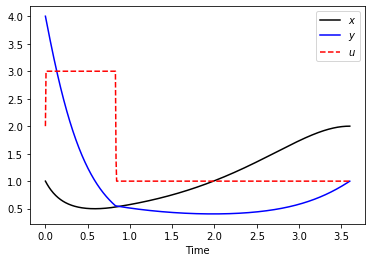

In [32]:
m = GEKKO(remote=False) # initialize GEKKO
nt = 501
m.time = np.linspace(0,1.0,nt)      ## Time discretisation != time optimisation
# print(m.time[:])

# Variables
x = m.Var(value=1)
y = m.Var(value=4)
p = np.zeros(nt) # final time = 1
p[-1] = 1.0
final = m.Param(value=p)

# optimize final time
tf = m.FV(value=1.0,lb=0.1,ub=5.0)
tf.STATUS = 1

# control changes every time period
u = m.MV(value=2,lb=1,ub=3)
u.STATUS = 1
m.Equation(x.dt() == x*(1.0-y)*tf)
m.Equation(y.dt() == -y*(u-x)*tf)

a = 2.0

m.Obj(tf + (1e6)*(x*final-a)**2 + (1e6)*(y*final-1.0)**2)       ## Penalisation
m.options.IMODE = 6

# m.options.COLDSTART=2
m.options.MAX_ITER=500
# m.options.SOLVER=0

m.solve(disp=False)
print('Final Time: ' + str(tf.value[0]))
print("Max and Min prey population:", np.max(y.VALUE), np.min(y.VALUE))
tm = np.linspace(0,tf.value[0],nt)
plt.figure(1)
plt.plot(tm,x.value,'k-',label=r'$x$')
plt.plot(tm,y.value,'b-',label=r'$y$')
plt.plot(tm,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
# plt.savefig("Tex/img/Exo3Test1")
plt.show()

### 2eme version
Modélisation du problème
\begin{align*}
	\begin{cases}
		x^\prime(t) = x(t)(1-y(t)) \\
		y^\prime(t) = -y(t)(u(t)-x(t))\\
		z^\prime(t) = u(t)^2 \\
		x(0)=1,\, y(0)=4, \, z(0)=0
	\end{cases}
\end{align*}
Minimisons $\inf_{u}{T+z(T)}$ tel que $x(T)=a$, $y(T)=1$.

Final Time: 3.3878988273
Final Cost: 16.1971496753


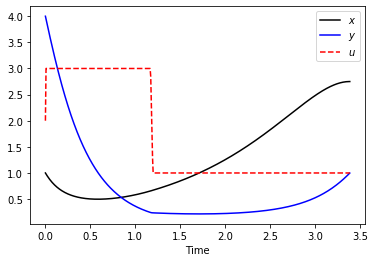

In [12]:
m = GEKKO() # initialize GEKKO
nt = 501
m.time = np.linspace(0,1.0,nt)
# print(m.time[:])

# Variables
x = m.Var(value=1)
y = m.Var(value=4)
z = m.Var(value=0)
p = np.zeros(nt) # final time = 1
p[-1] = 1
final = m.Param(value=p)

# optimize final time
tf = m.FV(value=5.0,lb=0.01,ub=100.0)
tf.STATUS = 1

# control changes every time period
u = m.MV(value=2,lb=1,ub=3)
u.STATUS = 1
m.Equation(x.dt()==x*(1-y)*tf)
m.Equation(y.dt()==-y*(u-x)*tf)
m.Equation(z.dt()==u**2*tf)
a = 2.75

m.Obj(tf + z*final + 1e5*(x*final-a)**2 + 1e5*(y*final-1)**2)       ## Penalisation
m.options.MAX_ITER=500
m.options.IMODE = 6
m.solve(disp=False)
print('Final Time: ' + str(tf.value[0]))
print('Final Cost: ' + str(tf.value[0] + z.VALUE[-1]))

tm = np.linspace(0,tf.value[0],nt)
plt.figure(1)
plt.plot(tm,x.value,'k-',label=r'$x$')
plt.plot(tm,y.value,'b-',label=r'$y$')
plt.plot(tm,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
# plt.savefig("Tex/img/Exo36")
plt.show()